### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

***Ваше решение тут***
1) $$-\frac{\partial L(F(x_i), y_i)}{\partial F} = 2(y_i - F(x_i)$$ \
2) $$-\frac{\partial L(F(x_i), y_i)}{\partial F} = y_i\exp{(-F(x_i)y_i)}$$ \
3) $$-\frac{\partial L(F(x_i), y_i)}{\partial F} = \frac{y_i}{1 + \exp{(F(x_i)y_i)}}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [2]:
class MyGradientBoostingClassifier:

    def __init__(self, loss="mse", learning_rate=0.1,
                 n_estimators=100, colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        
        self.base_model = None
        self.init_model = None
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.n_classes = np.unique(y).shape[0]
        if self.n_classes == 2:
            y = (y - 0.5) * 2

        self.init_model = init_model if init_model is None else init_model()
        self.base_model = base_model
        if init_model is not None:
            self.init_model.fit(X, y)
            F = self.init_model.predict(X)
        else:
            F = np.zeros(X.shape[0])
        
        self.ensemble = []
        
        colsample_num = round((self.colsample * X.shape[1]))
        subsample_num = round((self.subsample * X.shape[0]))
        for j in range(self.n_estimators):
            colsample_idx = np.random.choice(np.arange(X.shape[1]), size=colsample_num, replace=False)
            subsample_idx = np.random.choice(np.arange(X.shape[0]), size=subsample_num, replace=False)
            
            X_subsample = X[np.ix_(subsample_idx, colsample_idx)]
            y_subsample = y[subsample_idx]
            
            if self.loss == "mse":
                y_subsample = 2 * (y_subsample - F[subsample_idx])
            elif self.loss == "exponential":
                y_subsample = y_subsample * np.exp(-F[subsample_idx] * y_subsample)
            elif self.loss == "deviance":
                y_subsample = y_subsample / (1 + np.exp(F[subsample_idx] * y_subsample))
            else:
                raise NotImplementedError(self.loss)

            model = self.base_model(*self.args, **self.kwargs)
            model.fit(X_subsample, y_subsample)
            F[subsample_idx] += self.learning_rate * model.predict(X_subsample)
            self.ensemble.append((model, colsample_idx))
        
    def predict(self, X):
        assert(self.base_model is not None and "predict called before fit")
        
        if self.init_model is not None:
            intercept = self.init_model.predict(X)
        else:
            intercept = np.zeros(X.shape[0])

        f = np.zeros(X.shape[0])
        for model, colsample in self.ensemble:
            f += model.predict(X[:, colsample])
        F = np.round(intercept + self.learning_rate * f)
        if self.n_classes == 2:
            F[F >= 0] = 1
            F[F < 0] = 0
        return F

In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [8]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [9]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
X.shape, y.shape

((20640, 8), (20640,))

Организуем валидацию по 3 фолдам.

In [13]:
n_splits = 3
seed = 1000 - 7
np.random.seed(seed)
kf = StratifiedKFold(n_splits, shuffle=True, random_state=seed)

In [14]:
def validate(model, X, y, *args, **kwargs):
    score = np.zeros(n_splits)
    
    for j, (idxs_train, idxs_val) in enumerate(kf.split(X, y)):
        X_train, y_train = X[idxs_train], y[idxs_train]
        X_val, y_val = X[idxs_val], y[idxs_val]
        
        model.fit(X_train, y_train, *args, **kwargs)
        y_pred = model.predict(X_val)

        score[j] = accuracy_score(y_val, y_pred)

    return score.mean()

In [15]:
cls = MyGradientBoostingClassifier

Для начала построим график зависимости accuracy от числа итераций на валидации для разных функций потерь.

In [16]:
n_estimators_grid = np.arange(50, 150, 10)

score = {
    "mse": [],
    "exponential": [],
    "deviance": [],
}

for key in score:
    for n_estimators in n_estimators_grid:
        model = cls(loss=key, n_estimators=n_estimators)
        score[key].append(validate(model, X, y))
        
for key in score:
    print(f"For loss {key} best n_estimators {n_estimators_grid[np.argmax(score[key])]} with score {np.max(score[key])}")

For loss mse best n_estimators 140 with score 0.8306686046511628
For loss exponential best n_estimators 120 with score 0.8345930232558141
For loss deviance best n_estimators 140 with score 0.8340116279069768


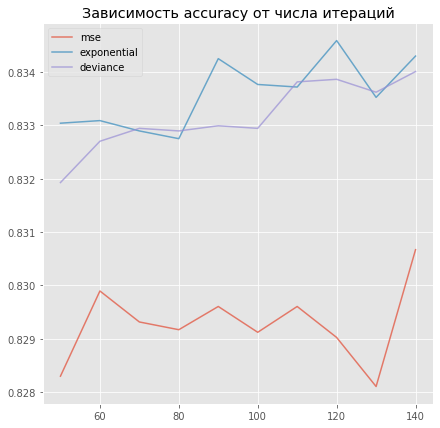

In [17]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

for key in score:
    ax.plot(n_estimators_grid, score[key], alpha=0.7, label=key)

ax.legend()
ax.set_title("Зависимость accuracy от числа итераций")
_ = _

Оптимизируем параметры

In [18]:
grid_params = {
    "learning_rate": np.linspace(0.0001, 1.0, num=20),
    "subsample": np.linspace(0.5, 1.0, num=20),
    "colsample": np.linspace(0.3, 1.0, num=20),
}

params = {
    "mse": {
        "n_estimators": 140,
        "learning_rate": 0.5,
        "subsample": 0.85,
        "colsample": 1.,
    },
    "exponential": {
        "n_estimators": 120,
        "learning_rate": 0.5,
        "subsample": 0.85,
        "colsample": 1.,
    },
    "deviance": {
        "n_estimators": 140,
        "learning_rate": 0.5,
        "subsample": 0.85,
        "colsample": 1.,
    },
}

In [19]:
score = {key: [] for key in params}
for key in params:
    for learning_rate in grid_params['learning_rate']:
        params[key]['learning_rate'] = learning_rate
        model = cls(loss=key, **params[key])
        score[key].append(validate(model, X, y))
    params[key]['learning_rate'] = grid_params['learning_rate'][np.argmax(score[key])]

In [20]:
score = {key: [] for key in params}
for key in params:
    for subsample in grid_params['subsample']:
        params[key]['subsample'] = subsample
        model = cls(loss=key, **params[key])
        score[key].append(validate(model, X, y))
    params[key]['subsample'] = grid_params['subsample'][np.argmax(score[key])]

In [21]:
score = {key: [] for key in params}
for key in params:
    for colsample in grid_params['colsample']:
        params[key]['colsample'] = colsample
        model = cls(loss=key, **params[key])
        score[key].append(validate(model, X, y))
    params[key]['colsample'] = grid_params['colsample'][np.argmax(score[key])]

In [22]:
scores = []
for key in params:
    print(params[key], key)
    model = cls(loss=key, **params[key])
    scores.append(validate(model, X, y))

best_loss = list(params.keys())[np.argmax(scores)]
best_params = params[best_loss]
best_score = np.max(scores)

{'n_estimators': 140, 'learning_rate': 0.05272631578947369, 'subsample': 0.5263157894736842, 'colsample': 0.7421052631578946} mse
{'n_estimators': 120, 'learning_rate': 0.3684842105263158, 'subsample': 0.5, 'colsample': 0.7421052631578946} exponential
{'n_estimators': 140, 'learning_rate': 0.21060526315789474, 'subsample': 0.5526315789473684, 'colsample': 0.5947368421052631} deviance


In [23]:
best_loss, best_score, best_params

('deviance',
 0.8945251937984495,
 {'n_estimators': 140,
  'learning_rate': 0.21060526315789474,
  'subsample': 0.5526315789473684,
  'colsample': 0.5947368421052631})

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
boobag = MyGradientBoostingClassifier(loss=best_loss, **best_params)
score = validate(boobag, X, y, base_model=RandomForestRegressor)
print("BooBag accuracy:", score)

BooBag accuracy: 0.8922480620155039


In [26]:
class BagBoo:
    def __init__(self, n, boosting, **kwargs):
        self.n = n
        self.boosting = boosting
        self.kwargs = kwargs

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n):
            bag_idx = np.random.choice(X.shape[0], size=X.shape[0], replace=False)
            model = self.boosting(**kwargs)
            model.fit(X[bag_idx], y[bag_idx])
            self.models.append(model)

    def predict(self, X):
        y_pred = np.zeros((n, X.shape[0]))
        for j, model in enumerate(self.models):
            y_pred_partial = model.predict(X)
            y_pred[j] = y_pred_partial
        return np.apply_along_axis(self.__voting, 0, y_pred)
    
    def __voting(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

In [27]:
n = 8
boosting = MyGradientBoostingClassifier
kwargs = dict(loss=best_loss, **best_params)
bagboo = BagBoo(n, boosting, **kwargs)
score = validate(bagboo, X, y)
print("BagBoo accuracy:", score)

BagBoo accuracy: 0.8941860465116279


***Вывод***: 

Качество улучшить не получилось. Это может быть связано с тем, что в случае стоит дополнительно подбирать параметры базовых моделей.

В целом, кажется, что при подборе параметров это иногда может привести к хорошему результату, тк использование bagging'а может уменьшить общий разброс (variance) модели, не ухудшая смещение (bias) (которое будет хорошо уменьшено бустингом).

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [29]:
init_linear = MyGradientBoostingClassifier(loss=best_loss, **best_params)
score = validate(init_linear, X, y, init_model=LinearRegression)
print("With initial linear model accuracy:", score)

With initial linear model accuracy: 0.8961240310077518


In [30]:
init_svm = MyGradientBoostingClassifier(loss=best_loss, **best_params)
score = validate(init_svm, X, y, init_model=SVR)
print("With initial SVM model accuracy:", score)

With initial SVM model accuracy: 0.8925387596899225


In [31]:
init_forest = MyGradientBoostingClassifier(loss=best_loss, **best_params)
score = validate(init_forest, X, y, init_model=RandomForestRegressor)
print("With initial random forest model accuracy:", score)

With initial random forest model accuracy: 0.8900678294573643


***Вывод***: 

Качество улучшилось в случае линейной модели, и ухудшилось в случае остальных. Это опять же может быть связано с тем, что стоит дополнительно подбирать параметры начальной модели. 

В целом кажется, что константа так хороша в качестве начальной модели, потому что она хоть и даёт высокое начальное смещение (bias) но имеет нулевой разброс (variance). А бустинг успешно уменьшает смещение и всё ок. А использование сложных (да к тому же и без подобранных параметров) моделей, может вносить слишком большой разброс, с которым бустинг почти ничего не сделает. Линейная модель имеет bias гарантированно меньше, чем константа (т.к. константа частный случай линейной модели), но при этом, если повезет, не слишком увеличивает разброс (может быть по этому результат и улучшился).

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

